# Load the Data

In [1]:
from pathlib import Path
import pandas as pd
import xxhash

Read in all Hacker News Stories from 2021, which [can be downloaded from Kaggle](https://www.kaggle.com/datasets/edwardjross/hackernews-2021-comments-and-stories) (extracted from the BigQuery dataset).

In [2]:
df = (
    pd
    .read_parquet('../data/01_raw/hackernews2021.parquet')
    .set_index('id')
)

In [3]:
df

,title,url,text,dead,by,score,time,timestamp,type,parent,descendants,ranking,deleted
id,,,,,,,,,,,,,
27405131,None,None,They didn&#x27;t say they <i>weren&#x27;t</i> ...,None,chrisseaton,NaN,1622901869,2021-06-05 14:04:29+00:00,comment,27405089.0,NaN,NaN,None
27814313,None,None,"Check out <a href=""https:&#x2F;&#x2F;www.remno...",None,noyesno,NaN,1626119705,2021-07-12 19:55:05+00:00,comment,27812726.0,NaN,NaN,None
28626089,None,None,Like a million-dollars pixel but with letters....,None,alainchabat,NaN,1632381114,2021-09-23 07:11:54+00:00,comment,28626017.0,NaN,NaN,None
27143346,None,None,Not the question...,None,SigmundA,NaN,1620920426,2021-05-13 15:40:26+00:00,comment,27143231.0,NaN,NaN,None
29053108,None,None,There’s the Unorganized Militia of the United ...,None,User23,NaN,1635636573,2021-10-30 23:29:33+00:00,comment,29052087.0,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27367848,None,None,Housing supply isn’t something that can’t chan...,None,JCM9,NaN,1622636746,2021-06-02 12:25:46+00:00,comment,27367172.0,NaN,NaN,None
28052800,None,None,Final Fantasy XIV has been experiencing consta...,None,amyjess,NaN,1628017217,2021-08-03 19:00:17+00:00,comment,28050798.0,NaN,NaN,None
28052805,None,None,How did you resolve it?,None,8ytecoder,NaN,1628017238,2021-08-03 19:00:38+00:00,comment,28049375.0,NaN,NaN,None


# Split the Data

The data will be split deterministically by the by the root story.
This allows using features about the comment thread.

## Finding the root

For each comment the root can be found by walking up the parents recursively.

In [4]:
parent_dict = df['parent'].fillna(df.index.to_series()).to_dict()

root_dict = {}

for item, parent in parent_dict.items():
    while parent in parent_dict:
        grandparent = parent_dict[parent]
        if parent == grandparent:
            break
        parent = grandparent
    root_dict[item] = parent
    
df['root'] = df.index.map(root_dict)

In [5]:
df['root'].head()

id
27405131    27404512.0
27814313    27807850.0
28626089    28625485.0
27143346    27142567.0
29053108    29043296.0
Name: root, dtype: float64

## Deterministic Splitting

The hash of the root id with a fixed salt gives a deterministic random split.
Choose a 50% training set.

In [6]:
def bucket(s, salt='hnbooks'):
    return xxhash.xxh32_intdigest(str(s)+salt) % 100

bucket = df['root'].apply(bucket)

df['bucket'] = bucket

df['train'] = bucket < 50

# Text Extraction

In [7]:
import numpy as np

In [8]:
import re
import html

patterns = {
    re.compile('<p>'): '\n\n',
    re.compile('<i>'): r'',
    re.compile('</i>'): r'',
    re.compile('<a href="([^"]*)"[^>]*>.*?</a>'): r'\1',
    re.compile('<pre><code>((?:.|\n)*?)</code></pre>', flags=re.MULTILINE): r'\1',
}

def clean_text(s):
    for match, sub in patterns.items():
        s = match.sub(sub, s)
    return html.unescape(s)

In [9]:
text = '<i>&gt; they’re the only ones who can use FLOC</i><p>It is available to everyone:<p><pre><code>    cohort = await document.interestCohort();\n</code></pre>\nSee <a href="https:&#x2F;&#x2F;github.com&#x2F;WICG&#x2F;floc" rel="nofollow">https:&#x2F;&#x2F;github.com&#x2F;WICG&#x2F;floc</a><p>(Disclosure: I work for Google, speaking only for myself)'

print(text)

<i>&gt; they’re the only ones who can use FLOC</i><p>It is available to everyone:<p><pre><code>    cohort = await document.interestCohort();
</code></pre>
See <a href="https:&#x2F;&#x2F;github.com&#x2F;WICG&#x2F;floc" rel="nofollow">https:&#x2F;&#x2F;github.com&#x2F;WICG&#x2F;floc</a><p>(Disclosure: I work for Google, speaking only for myself)


In [10]:
result = (clean_text(text))

print(result)

> they’re the only ones who can use FLOC

It is available to everyone:

    cohort = await document.interestCohort();

See https://github.com/WICG/floc

(Disclosure: I work for Google, speaking only for myself)


# Joining Features

In [11]:
sample = df.query('train & dead.isna() & deleted.isna()').copy()

del df

In [12]:
ask_hn_data = pd.read_parquet('../data/02_intermediate/ask_hn_books.parquet')
seed_data = pd.read_parquet('../data/02_intermediate/seed_books.parquet')
zero_shot_data = pd.read_parquet('../data/02_intermediate/zero_shot_contains_book_title_predictions.parquet')
work_of_art_data = pd.read_parquet('../data/02_intermediate/work_of_art_predictions.parquet')


In [13]:
sample = (
    sample
    .merge(ask_hn_data, left_index=True, right_index=True, how='left', validate='1:1')
    .merge(seed_data, left_index=True, right_index=True, how='left', validate='1:1')
    .merge(zero_shot_data, left_index=True, right_index=True, how='left', validate='1:1')
    .merge(work_of_art_data, left_index=True, right_index=True, how='left', validate='1:1')
)

In [14]:
sample = sample.assign(
    comment_text = text,
    text = lambda _: (np.where(_.title.isna(), '', _.title) + 
                      np.where(~_.title.isna() & ~_.text.isna(), '<p>', '') +
                      _.text.fillna('')
                      ).apply(clean_text))

Almost every field has each of the scores, except `prob` and `work_of_art` which were just scored on comments

In [15]:
sample.isna().mean().to_frame().T

,title,url,text,dead,by,score,time,timestamp,type,parent,...,bucket,train,ask_hn_books,seed_book,seed_child,seed_parent,seed_sibling,prob,work_of_art,comment_text
0,0.924893,0.929302,0.0,1.0,0.000005,0.924799,0.0,0.0,0.0,0.075201,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fixing up seed sibling

In the definition of `seed_sibling` we looked at the children of parents - that includes the item itself.


Ideally we'd only include it when another sibling is a `seed_book` but for simplicity let's just exclude `seed_book`s

In [16]:
sample['seed_sibling'] = sample['seed_sibling'] & ~sample['seed_book']

# Coverage and Correlation

For each of these heuristics we want to answer:

1. How many comments with works does it contain?
2. Does it add something not in the other heuristics?
3. What's the precision?

We can make some ground on 1 and 2, but 3 requires some annotation

## Coverage

## Zero shot classifier

For the zero shot classifier we need to choose a cutoff probability to determine the coverage.

We can plot this by seeing the number of items with a cutoff of x below 1; e.g. around 90% it's around 200k

<AxesSubplot:ylabel='Frequency'>

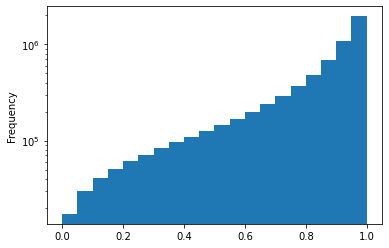

In [17]:
(1-sample['prob']).plot.hist(bins=20, log='y', cumulative=True)

Looking at the distribution of probabilities it has a minimum near 80%, which suggests this is a reasonable decision boundary.

<AxesSubplot:ylabel='Frequency'>

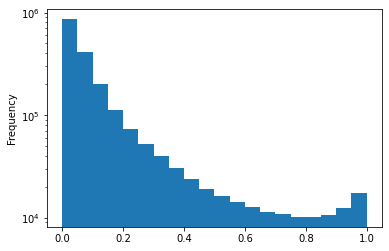

In [18]:
sample['prob'].plot.hist(bins=20, log='y')

We can also check this directly at different cutoff points

In [19]:
pd.DataFrame([(x, (sample['prob'] > x).sum()) for x in [0.8, 0.9, 0.95]], columns=['cutoff', 'n'])

,cutoff,n
0,0.80,50480
1,0.90,29597
2,0.95,17062


In [20]:
sample['zero_shot_80'] = sample['prob'] > 0.8

## All fields

In [21]:
sample.filter(regex='ask_hn|seed_|work_of_art|zero_shot_80').sum().sort_values(ascending=False).to_frame().T

,work_of_art,zero_shot_80,seed_sibling,seed_book,seed_child,seed_parent,ask_hn_books
0,55878,50480,13018,1184,1148,922,864


## Correlation

https://en.wikipedia.org/wiki/Association_rule_learning#Confidence

In [22]:
def confidence(x, y):
    return (sample[x] & sample[y]).sum() / sample[x].sum()

In general this is really promising, `work_of_art` and `zero_shot_80` have the most coverage and agree about 1/4 of the time.
They also both contain many of the examples from `seek_book` which are very likley to be actual examples, `work_of_art` doing particularly well.

Observations:
* most `seed_book` occur in `work_of_art`; this shows `work_of_art` is good at picking up common book names!
* If we assume `work_of_art` and `zero_shot_80` are good indicators: `seed_book` ~ `ask_hn_books` > `seed_child` > `seed_parent` > `seed_sibling`
* 1/3 of `ask_hn_books` are a `seed_sibling` which shows this is a good heuristic

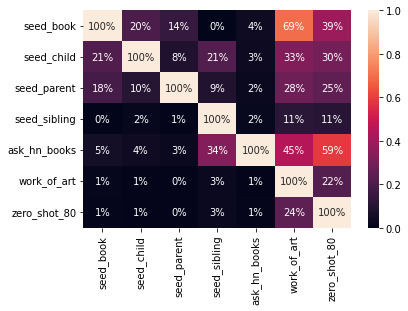

In [23]:
import seaborn as sns

cols = ['seed_book', 'seed_child', 'seed_parent', 'seed_sibling', 'ask_hn_books', 'work_of_art', 'zero_shot_80']

confidences = pd.DataFrame(index=cols, columns=cols, dtype='float')

for col1 in cols:
    for col2 in cols:
        confidences.loc[col1, col2] = confidence(col1, col2)
        
ax = sns.heatmap(confidences, annot=True, fmt="0.0%")

# Saving Samples

Export samples for annotation in [prodigy](prodi.gy) which expects a `text` column with the details and any information in a `meta` column.

In [24]:
def prodigy_prepare(df, meta_cols=None, meta_index=True, text_col='text'):
    if meta_cols is None:
        meta_cols = []
    if meta_index:
        if df.index.names in df.columns:
            raise ValueError("Index")
        meta_cols = df.index.names + meta_cols
        df = df.reset_index()
    
    meta = df[meta_cols].to_dict(orient='records')
    
    return pd.DataFrame({'text': df[text_col],
                         'meta': meta})

In [25]:
def prodigy_write(df, output_file, meta_cols=None, meta_index=True, text_col='text'):
    df_out = prodigy_prepare(df, meta_cols, meta_index, text_col)
    df_out.to_json(output_file, orient='records', lines=True)

In [26]:
cols

['seed_book',
 'seed_child',
 'seed_parent',
 'seed_sibling',
 'ask_hn_books',
 'work_of_art',
 'zero_shot_80']

In [27]:
len(sample) / 1e6

1.947961

In [28]:
prodigy_write(sample.sample(frac=1), meta_cols=cols, output_file='../data/02_intermediate/sample_data.jsonl')

In [29]:
cols

['seed_book',
 'seed_child',
 'seed_parent',
 'seed_sibling',
 'ask_hn_books',
 'work_of_art',
 'zero_shot_80']

In [30]:
for col in cols:
    prodigy_write(sample.query(col).sample(frac=1, random_state=349),
                  meta_cols=cols,
                  output_file=f'../data/02_intermediate/sample_{col}.jsonl')